Importing modules

In [4]:
import numpy as np
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
%matplotlib widget
from helpers import get_pixel
import astropy.units as u
from scipy.optimize import curve_fit

# Get pixels along a given line

In [5]:
def get_pixels_along_line(x_start, y_start, x_end, y_end, distances):
    vec = np.array([x_end - x_start, y_end - y_start])
    length = np.linalg.norm(vec)
    unit_vec = vec / length
    points = np.array([x_start, y_start])[:, None] + unit_vec[:, None] * distances
    x_pixels = np.round(points[0, :]).astype(int)
    y_pixels = np.round(points[1, :]).astype(int)
    return list(zip(x_pixels, y_pixels))

In [6]:
def perpendicular(x_start, y_start, x_end, y_end, center, segment_length=6):
    line_vec = np.array([x_end - x_start, y_end - y_start])
    line_length = np.linalg.norm(line_vec)
    unit_vec = line_vec / line_length
    perp_vec = np.array([-unit_vec[1], unit_vec[0]])
    half_len = segment_length / 2
    x_c = center[0]
    y_c = center[1]
    
    start_pt = np.array([x_c, y_c]) - perp_vec * half_len
    end_pt = np.array([x_c, y_c]) + perp_vec * half_len
    
    return [start_pt, end_pt]

In [ ]:
fits_file = '../fits/4s3d.fits'
lambda_0 = 1.644 *u.um # 1.644 for [Fe II], 2.8025 for H2
cube = SpectralCube.read("../fits/normal_cube4.fits") # note this is unitless
vcube = cube.with_spectral_unit(u.km/u.s, velocity_convention='optical',rest_value=lambda_0)

vel_axis = vcube.spectral_axis
target_velocity = -150 * u.km/u.s # -150 for Fe II, -110 for H2
vel_index = np.argmin(np.abs(vel_axis - target_velocity))

flux_slice = vcube.filled_data[vel_index, :, :]

ra = 69.896675   * u.degree
dec = 25.69561666667 * u.degree

# Define start and end points in pixel coordinates (x, y)
x1, y1 = get_pixel(cube, ra, dec) # starting point
x1 -= 2
y1 -= 1 # THESE ARE NOT REAL

endpoints = [(28.5,49), (28.5,49.5), (29,49), (28.5,48.5)]
all_distances = []
all_flux = []
n_points = 500

In [ ]:
for x_end, y_end in endpoints:
    x_vals = np.linspace(x1, x_end, n_points)
    y_vals = np.linspace(y1, y_end, n_points)

    x_inds = np.round(x_vals).astype(int)
    y_inds = np.round(y_vals).astype(int)

    # Get flux along this line
    flux_values = [flux_slice[y, x] for x, y in zip(x_inds, y_inds)]
    distances = np.sqrt((x_vals - x1)**2 + (y_vals - y1)**2)

    all_distances.extend(distances)
    all_flux.extend(flux_values)

# Convert to arrays
all_distances = np.array(all_distances)
all_flux = np.array(all_flux)

# Sort by distance to avoid overlapping step plot
sorted_indices = np.argsort(all_distances)
all_distances = all_distances[sorted_indices]
all_flux = all_flux[sorted_indices]

bin_width = 0.5  # pixels
bin_edges = np.arange(0, np.max(all_distances) + bin_width, bin_width)

# Step 2: Digitize distances → bin index for each point
bin_indices = np.digitize(all_distances, bin_edges)

# Step 3: Compute average flux in each bin
binned_flux = []
binned_distance = []

for i in range(1, len(bin_edges)):
    in_bin = bin_indices == i
    if np.any(in_bin):
        avg_flux = np.mean(all_flux[in_bin])
        mid_distance = 0.5 * (bin_edges[i] + bin_edges[i - 1])
        binned_flux.append(avg_flux)
        binned_distance.append(mid_distance)

binned_flux = np.array(binned_flux)
binned_distance = np.array(binned_distance)

/var/folders/_j/mydjhq1179jffd525zbvkvyh0000gn/T/ipykernel_89165/2392299664.py:40: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(flux_slice.value), origin='lower', cmap='inferno', vmin=-1, vmax=1)


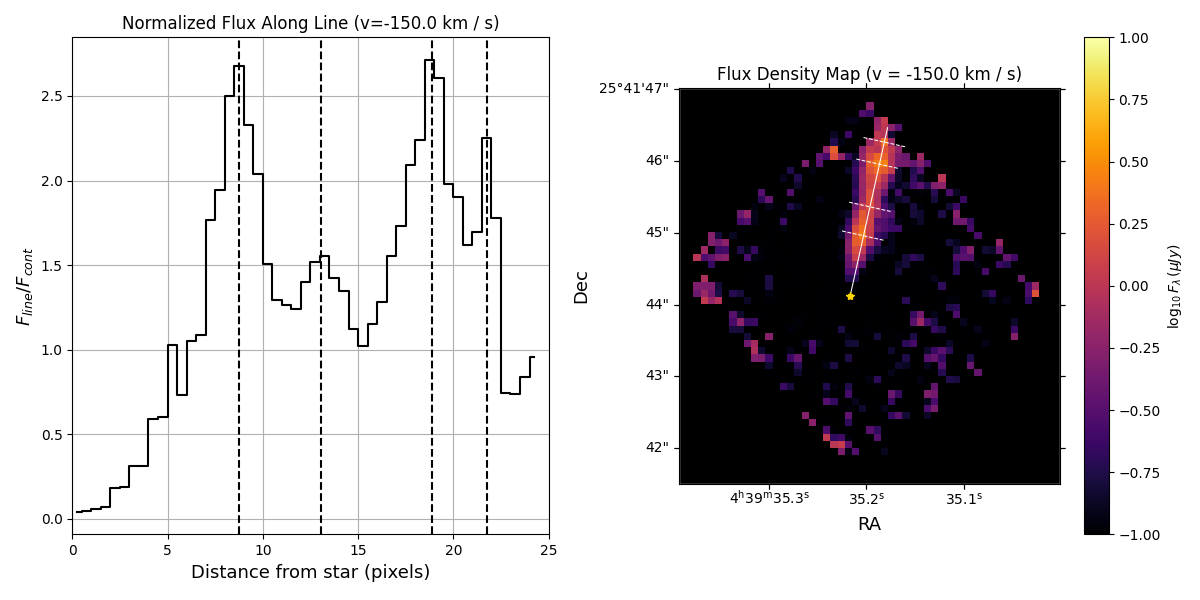

In [11]:
fig = plt.figure(figsize=(12, 6))

# Plot the profile
ax = plt.subplot(121)
ax.plot(binned_distance, binned_flux, drawstyle='steps-mid', color='black') # Spectrum

def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-(x - mean)**2 / (2 * sigma**2))

peak_ranges = [(15,21), (24,28), (35,41), (42,46)] # for 1.644
# peak_ranges = [(23,27), (32,36), (42,45)] # for 2.803
peak_distances = []
for i, (start, end) in enumerate(peak_ranges):
    x_vals = binned_distance[start:end]
    y_vals = binned_flux[start:end]

    # Initial guesses
    amp_guess = y_vals.max()
    mean_guess = x_vals[np.argmax(y_vals)]
    sigma_guess = (end - start) / 5

    try:
        popt, _ = curve_fit(gaussian, x_vals, y_vals, p0=[amp_guess, mean_guess, sigma_guess])
        fit_flux = gaussian(x_vals, *popt)
        # ax.plot(x_vals, fit_flux, color='black', label=f'Peak {i+1} Fit')
        ax.axvline(popt[1], linestyle='--', color='black', label=f'Peak {i+1} @ {popt[1]:.1f}')
        peak_distances.append(popt[1])
    except RuntimeError:
        print(f"Could not fit peak {i+1}")

ax.set_xlabel("Distance from star (pixels)", fontsize=13)
ax.set_xlim(0,25)
ax.set_ylabel("$F_{line}/F_{cont}$", fontsize=13)
ax.set_title(f"Normalized Flux Along Line (v={target_velocity})")
ax.grid(True)

# Plot the flux density map
ax = plt.subplot(122, projection=vcube.wcs.celestial)

im = ax.imshow(np.log10(flux_slice.value), origin='lower', cmap='inferno', vmin=-1, vmax=1)
ax.plot([x1, endpoints[0][0]], [y1, endpoints[0][1]], color='white', linewidth = 0.75) # overplot white line

# Plot perpendicular lines indicating peaks
peak_pixels = get_pixels_along_line(x1, y1, endpoints[0][0], endpoints[0][1], peak_distances)
peak_pixels = [(int(x), int(y)) for x, y in peak_pixels]

for p in peak_pixels:
    perp = perpendicular(x1, y1, endpoints[0][0], endpoints[0][1], p)
    p1 = perp[0]
    p2 = perp[1]
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='white', linestyle='--', linewidth = 0.75)


ax.plot(x1, y1, marker='*', color='gold')
ax.set_facecolor('black')
ax.set_xlabel("RA", fontsize=13)
ax.set_ylabel("Dec", fontsize=13)
ax.set_title(f'Flux Density Map (v = {target_velocity})')

plt.colorbar(im, ax=ax, label='$\log_{10} F_\lambda \, (\mu Jy)$')
fig.subplots_adjust(top=0.88, bottom=0.3)
plt.tight_layout()
plt.show()